In [3]:
import json, os, glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

def time2frame(time, fps=30, frameFreq=4):
    h, m, s = time.split(":")
    frame = ( int(h)*3600 + int(m)*60 + float(s)*1 )*fps
    frame = int( frame//frameFreq*frameFreq + (frame%frameFreq>=frameFreq/2)*frameFreq )
    return frame

def frame2time(frame, fps=30):
    frame = int(frame)/fps
    h, frame = str(int(frame//3600)), frame%3600
    m, s = str(int(frame//60)), round(frame%60,2)
    return f"{ '0'*(2-len(h)) + h }:{ '0'*(2-len(m))+m }:{s}"

time  = "00:01:27.50"
frame = time2frame(time)
timex = frame2time(frame)
print( time, frame, timex )

class DownstreamResult:
    def __init__(self, labelPath, resultPath, classL):
        self.labelPath, self.resultPath, self.classL, self.framesPerStack = labelPath, resultPath, classL, 16
        self.df = pd.read_csv(labelPath, header=None, delimiter=' ').rename(columns={0:"video",1:"GT"})
        self.df["video"] = self.df["video"].apply(lambda s:'/'.join(s.split('/')[-2:]))
        resultL = json.load(open(f"{resultPath}/result.json",'r'))
        resultL = [ max(zip(L,range(len(L)))) for L in resultL ]
        self.df['pred_cf'], self.df['pred_cls'] = zip(*resultL)
        self.right_df = self.df[ self.df["GT"]==self.df['pred_cls'] ].sort_values(by=["pred_cf"])
        self.wrong_df = self.df[ self.df["GT"]!=self.df['pred_cls'] ].sort_values(by=["pred_cf"])
        print(f"all={len(self.df)}, right={len(self.right_df)}, wrong={len(self.wrong_df)}, accuracy={round(len(self.right_df)/len(self.df),3)}")
        
    def get_dfs(self, right=False, wrong=False):
        print(f"self.right_df\n{self.right_df}") if right else None
        print(f"self.wrong_df\n{self.wrong_df}") if wrong else None
        
    def plotConfusion(self):
        classCountDict = self.df["GT"].value_counts().to_dict()
        print(f"classCountDict={classCountDict}")
        n = len(self.classL)
        M, R = np.zeros((n,n)), np.zeros((n,n))
        for i in range(len(self.df)):
            _, gt, _, pd = self.df.loc[i]
            M[gt][pd]+=1
            R[gt][pd]+=1/classCountDict[gt]
        R = np.round(R,3)
        P = np.round(M.copy()/M.sum(axis=0),3)
        plt.figure(figsize=(18,4))
        #
        plt.subplot(1,3,1)
        plt.title("Number", fontsize=14)
        plt.xlabel("PD")
        plt.ylabel("GT")
        plt.xticks(range(n),self.classL, fontsize=14)
        plt.yticks(range(n),self.classL, fontsize=14)
        plt.imshow(R, cmap=mpl.cm.Blues)
        plt.colorbar()
        for i in range(n):
            for j in range(n):
                plt.annotate(int(M[i][j]), xy=(j,i), ha="center", va="center", color="black" if R[i][j]<0.5 else "white", fontsize=14)
        #
        plt.subplot(1,3,2)
        plt.title("row normalized (recall)", fontsize=14)
        plt.xlabel("PD")
        plt.ylabel("GT")
        plt.xticks(range(n),self.classL, fontsize=14)
        plt.yticks(range(n),self.classL, fontsize=14)
        plt.imshow(R, cmap=mpl.cm.Blues)
        plt.colorbar()
        for i in range(n):
            for j in range(n):
                plt.annotate(R[i][j], xy=(j,i), ha="center", va="center", color="black" if R[i][j]<0.5 else "white", fontsize=14)
        #
        plt.subplot(1,3,3)
        plt.title("col normalized (precision)", fontsize=14)
        plt.xlabel("PD")
        plt.ylabel("GT")
        plt.xticks(range(n),self.classL, fontsize=14)
        plt.yticks(range(n),self.classL, fontsize=14)
        plt.imshow(P, cmap=mpl.cm.Blues)
        plt.colorbar()
        for i in range(n):
            for j in range(n):
                plt.annotate(P[i][j], xy=(j,i), ha="center", va="center", color="black" if P[i][j]<0.5 else "white", fontsize=14)
        plt.savefig(f"{self.resultPath}/confusion.jpg")
        plt.show()
        print( np.diagonal(R).mean(), np.diagonal(P).mean() )
        
    def getWrongVideos(self):
        # collect idx2path (imgPathL) & path2idx (imgPathD)
        imgPathL = []
        dateS    = set(obj.wrong_df['video'].apply(lambda s:s.split("/")[0]).to_list())
        for date in dateS:
            imgPathL += sorted( glob.glob( os.path.abspath(f"{self.labelPath}/../../../imgs/{date}/*.jpg") ) )
        imgPathD = dict( zip( imgPathL,range(len(imgPathL)) ) )
        # save
        for i in range(len(self.wrong_df)):
            video, gt, _, pred_cls = self.wrong_df.iloc[i]
            startIdx  = imgPathD[ os.path.abspath(f"../_data/imgs/{video}") ]
            desFolder = f"{self.resultPath}/wrong/GT_{gt}_PD_{pred_cls}_{ os.path.basename(video)[:-4] }"
            os.makedirs(desFolder, exist_ok=True)
            for j in range(self.framesPerStack):
                srcPath = imgPathL[startIdx+j]
                os.system(f"cp {srcPath} {desFolder}/{os.path.basename(srcPath)}")
                
    def visWrongVideos(self):
        for stackPath in glob.glob(f"{self.resultPath}/wrong/*"):
            print( os.path.basename(stackPath), "|", frame2time(stackPath.split("_")[-1]) )
            plt.figure(figsize=(6*5,4*4))
            for idx,imgPath in enumerate(glob.glob(f"{stackPath}/*.jpg")):
                plt.subplot(4, 4, 1+idx)
                plt.imshow( cv2.imread(imgPath)[:,:,::-1] )
                plt.axis('off')
            plt.show()

00:01:27.50 2624 00:01:27.47


all=176, right=176, wrong=0, accuracy=1.0
self.right_df
                                       video  GT   pred_cf  pred_cls
60   20220826/video_20220826000720_02892.jpg   0  0.553711         0
85   20220826/video_20220826000220_05436.jpg   3  0.573730         3
16   20220826/video_20220826000720_02380.jpg   2  0.765625         2
139  20220826/video_20220826001721_07588.jpg   3  0.769043         3
100  20220826/video_20220826001721_00016.jpg   1  0.869141         1
..                                       ...  ..       ...       ...
99   20220826/video_20220826001221_07916.jpg   1  1.000000         1
98   20220826/video_20220826000720_08284.jpg   2  1.000000         2
42   20220826/video_20220826000220_07696.jpg   3  1.000000         3
111  20220826/video_20220826000220_08820.jpg   1  1.000000         1
175  20220826/video_20220826002221_07148.jpg   3  1.000000         3

[176 rows x 4 columns]
self.wrong_df
Empty DataFrame
Columns: [video, GT, pred_cf, pred_cls]
Index: []
classCountDi

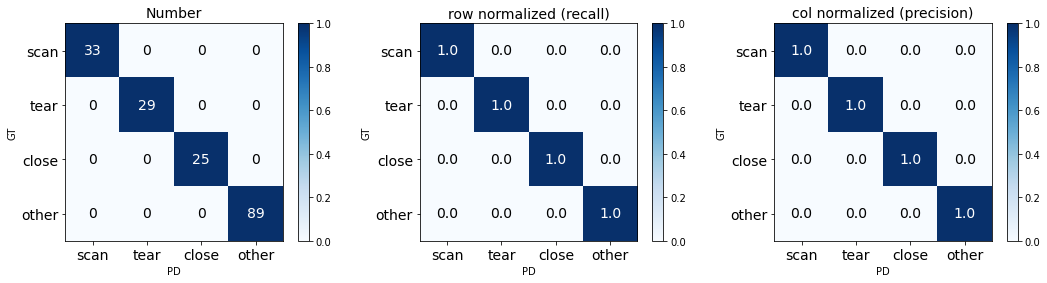

1.0 1.0


In [4]:
obj = DownstreamResult(labelPath="../_data/csvDownstream/20220826_v2/val.csv", resultPath="../_exps/downstream_0826_v2", classL=["scan","tear","close","other"])
obj.get_dfs(right=True, wrong=True)
obj.plotConfusion()
#obj.getWrongVideos()
#obj.visWrongVideos()